# Project 1 Code
### Serena Tang, Liwen Yang, Winston Wang

## Getting familiar with the dataset

In [1]:
import pandas as pd
df = pd.read_csv('Project1-Classification.csv')
print('Shape of Project1-Classification:', df.shape)

Shape of Project1-Classification: (3150, 8)


### Question 1

***Overview: How many rows (samples) and columns (features) are present in the dataset?***

There are 3150 rows (samples) and 8 columns (features) in the data set. 

***Histograms: Plot 3 histograms on: (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis.***

Text(0, 0.5, 'Frequency')

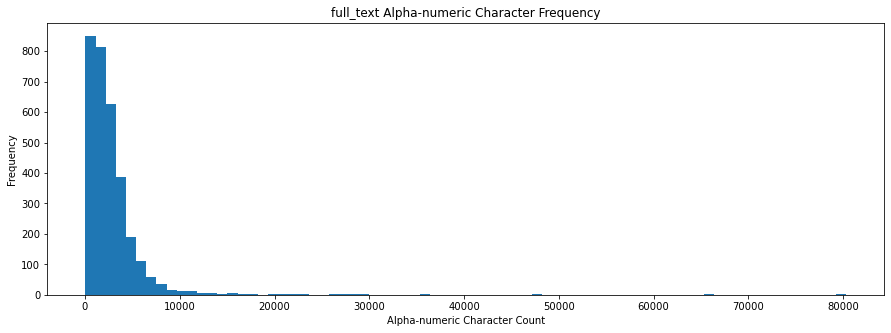

In [2]:
# counting alpha-numeric characters in full_text
import re
import matplotlib.pyplot as plt
full_text=df.full_text
full_text_count = []
for text in full_text:
    text = text.replace('\n','')
    text = re.sub(r'[^a-zA-Z0-9]','',text)
    full_text_count.append(len(text))
    
# plot frequency     
plt.rcParams['figure.figsize'] = (15, 5)
plt.hist(full_text_count,bins = 75)
plt.title('full_text Alpha-numeric Character Frequency')
plt.xlabel('Alpha-numeric Character Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

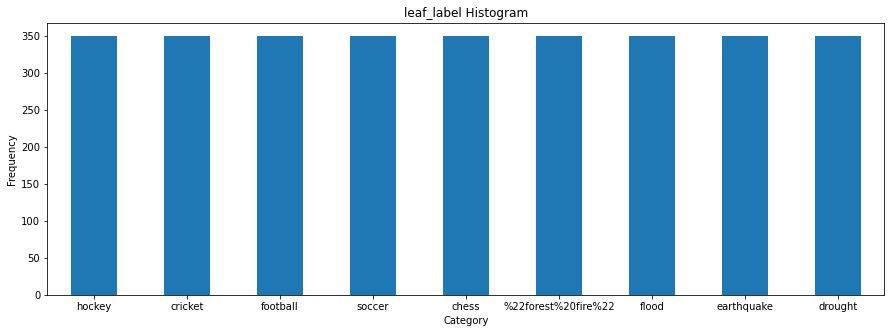

In [3]:
# histogram of leaf_label
df['leaf_label'].value_counts().plot(kind = 'bar',rot = 0)
plt.title('leaf_label Histogram')
plt.xlabel('Category')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

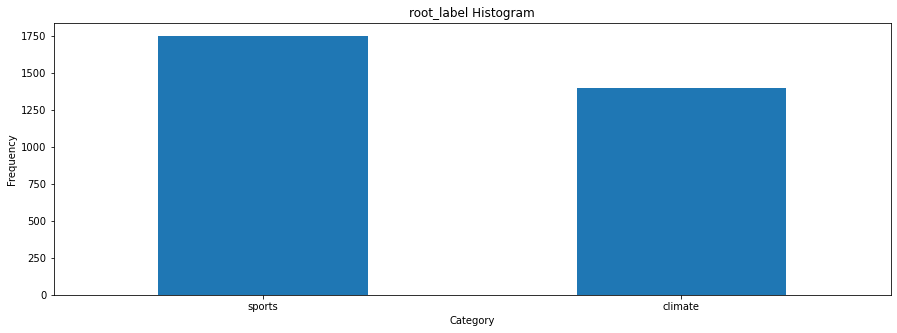

In [4]:
# histogram of root_label
df['root_label'].value_counts().plot(kind ='bar',rot = 0)
plt.title('root_label Histogram')
plt.xlabel('Category')
plt.ylabel('Frequency')

***Interpret Plots: Provide qualitative interpretations of the histograms.***

The alpha-numeric histogram right skewed with an average around 2,500 characters. Additionally, most alpha-numeric character counts lie within 0 and 10,000.

The leaf_label histogram is evenly distributed as all categories have the same frequency, which is 350.

The root_label histogram is not evenly distributed. The sports category appears more frequently than the climate category; sports appears 1750 times while climate appears 1400 times. 

## Binary Classification

In [5]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size = 0.2)
print('Train data size:', train.shape)
print('Test data size:', test.shape)

Train data size: (2520, 2)
Test data size: (630, 2)


### Question 2

***Report the number of training and testing samples***

There are 2520 training samples and 630 testing samples

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [8]:
# clean text and remove numbers and punctuation
import string
table = str.maketrans(dict.fromkeys(string.punctuation))

def clean_text(text, table):
    for i in list(text.index):
        text[i] = clean(text[i])
        text[i] = text[i].translate(table)
        text[i] = re.sub(r'\S*\d\S*','',text[i])
        text[i] = text[i].lower()
    return text

train.full_text=clean_text(train.full_text, table)
test.full_text=clean_text(test.full_text, table)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
from sklearn.feature_extraction.text import TfidfTransformer

wnl = WordNetLemmatizer()

# get pos of word
def get_pos(tag):
    pos_dict = {'JJ':'a', 'NN':'n', 'RB':'r', 'VB':'v'}
    if tag[1][:2] in list(pos_dict.keys()):
        return pos_dict[tag[1][:2]]
    else:
        return 'n'
    
# lemmatize text
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    tags = pos_tag(tokens)
    return  [wnl.lemmatize(pair[0],get_pos(pair)) for pair in tags]

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english', analyzer = lemmatize_text)
train_vectorized = tf_vectorizer.fit_transform(train.full_text)
test_vectorized = tf_vectorizer.transform(test.full_text)

# count vector to TF-IDF
transformer = TfidfTransformer()
train_tfidf = transformer.fit_transform(train_vectorized)
test_tfidf = transformer.transform(test_vectorized)

In [10]:
#train_vectorized = tf_vectorizer.fit_transform(train.full_text)
print('Train TF-IDF matrix size:', train_tfidf.shape)
#test_vectorized = tf_vectorizer.transform(test.full_text)
print('Test TF-IDF matrix size:', test_tfidf.shape)

Train TF-IDF matrix size: (2520, 14465)
Test TF-IDF matrix size: (630, 14465)


### Question 3

***What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?***

Lemmatizing considers the morphology of the word being analysed; however, it requires the words correct part of speech to accurately lemmatize it. For example, the word `dusting` requires it to be identified as a verb to correctly result in the lemma  `dust`. If it is identified as a noun (as it is the default part of speech when using the lemmatize function ), the lemma `dusting` will be returned. On the other hand, stemming only removes the end portions of a word to try to find its stem. However, it maybe inaccurately stem a word. For example, stemming the word `carries` may result in the word `car` or `carri`, which are both incorrect. 

Both lemmatization and stemming will reduce the dictionary size as only the lemma or stems of words are kept after the process is applied. So for words like `running` and `ran`, only the lemma `run` would be kept; this is how the dictionary size would decrease. For this same reason, it will also help to reduce the run time of the algorithm as less words are processed by the algorithm. If all words in a text are already in their lemma or stem form, it will not change the dictionary size. 

***min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?***

When using CountVectorizer, min_df is used to filter out words that have a frequency below min_df. Increasing this value will filter out more words and thus decrease the TF-IDF matrix columns. Decreasing the value will increase the TF-IDF matrix columns. This change in the matrix can affect the results of the analysis being done. 

 
***Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.***

Punctuations and numbers should be removed before lemmatizing as words with punctuations included are treated differently than the same word without punctuation, such as `fun!` and `fun`. Additionally, numbers are not as important when analysing the text. Removing stopwords before or after lemmatizing depends what the task requires. In cases where they may not be very useful or necessary (like sentiment analysis), they should be removed before lemmatizing. To determine whether lemmatizing should come before or after stopword removal, the intent of the task should be examined to see if they are necessary. Additionally, the task can be done with both methods to determine whether it is better the lemmatize before or after stopword removal. Additionally, the removal of these elements will reduce the run time of the algorithm analysing the text as there are less words that must be processed. 

***Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.***

The shape of the train matrix is (2520, 14465) and the shape of the test matrix is (630, 14465); for both, the number of rows match the results from section 2. 


### Question 4

***Plot the explained variance ratio across multiple different k = [1,10,50,100,200,500,1000,2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?***

Text(0, 0.5, 'Explained Variance Ratio')

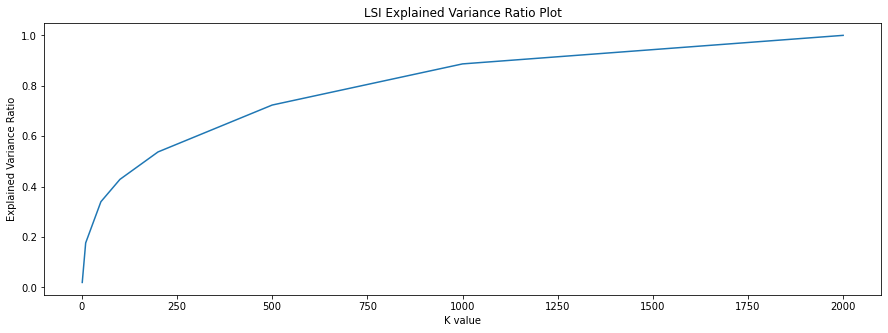

In [11]:
# Latent Semantic Indexing (LSI)

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

k = [1,10,50,100,200,500,1000,2000]
reduced_svd = [] 
explained_var = []

for i in range(len(k)):
    reduced_svd.append(TruncatedSVD(n_components=k[i], random_state=42)) # append truncated SVD
    reduced_svd[i].fit_transform(train_tfidf) # train on train tf_idf
    explained_var.append(reduced_svd[i].explained_variance_ratio_.sum()) # calculate explained variance ratio

plt.plot(k,explained_var)
plt.title('LSI Explained Variance Ratio Plot')
plt.xlabel('K value')
plt.ylabel('Explained Variance Ratio')

The concavity in the explained variance ratio plot suggests that as the K value increases, the more the amount of variance is explained. This implies that while performing dimensionality reduction, there is a trade off between the number of elements kept and the amount of variance explained. For example, if k=2, the variance explained ratio is about 0.18; this implies that the dimensionality reduce will lose a lot of data. However, is k=1000, we are able to reduce our training data by about a third while still having a variance explained ratio of about 0.89.

In [12]:
from sklearn.decomposition import NMF
from numpy import linalg

k = 50

# LSI error

# transform reduced train data back to original form
train_LSI = reduced_svd[2].inverse_transform(reduced_svd[2].transform(train_tfidf))
LSI_mse = linalg.norm(np.subtract(train_tfidf.toarray(), train_LSI), 'fro')**2
print('LSI MSE: ', LSI_mse)

# NMF error
NMFmodel = NMF(n_components=k, init='random', random_state=42, max_iter=300)
W = NMFmodel.fit_transform(train_tfidf)
H = NMFmodel.components_
train_NMF = NMFmodel.inverse_transform(W)
NMF_mse = linalg.norm(np.subtract(train_tfidf.toarray(), train_NMF), 'fro')**2
print('NMF MSE: ', NMF_mse)

LSI MSE:  1419.657741630812
NMF MSE:  1449.0553177645415


***With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $\lVert X −WH\rVert^{2}_{F}$ in NMF or the $\lVert X −U_k\Sigma _kV^T_k\rVert^{2}_{F}$ in LSI and why?***

The residual MSE error using NMF is larger as $\lVert X −WH\rVert^{2}_{F}$=1449 and $\lVert X −U_k\Sigma _kV^T_k\rVert^{2}_{F}$=1419.7. This larger error is due to the fact that NMF is restricted to only having non-negative W and H matrices while LSI does not have any restrictions. The negative elements in the truncated SVD used in LSI allows for a less restricted approximation of X and its reduced dimensionality. 

### Question 5

Train two linear SVMs:
- Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).
- Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?
- What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.
    - Does the ROC curve reflect the performance of the soft-margin SVM? Why?
- Use cross-validation to choose γ (use average validation accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {$10^k$ | − 3 ≤ k ≤ 6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

In [13]:
from sklearn import svm
from sklearn import metrics
import seaborn as sn
from sklearn.preprocessing import LabelEncoder

# transform categories into number (Climate=0, Sports=1)
Encoder = LabelEncoder()
train['binary_root_label']=Encoder.fit_transform(train['root_label'])
test['binary_root_label']=Encoder.fit_transform(test['root_label'])

train_trunc = reduced_svd[2].fit_transform(train_tfidf)
test_trunc = reduced_svd[2].transform(test_tfidf)

In [14]:
def train_SVM(c, train, train_label, test, test_label):
    SVM = svm.SVC(kernel='linear', C=c, random_state=42) # train svm
    SVM.fit(train, train_label)
    prob_score = SVM.decision_function(test)
    fpr, tpr, _= metrics.roc_curve(test_label,prob_score) # plot roc curve
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    plt.grid(color='0.7', linestyle='--', linewidth=1)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.legend(loc="lower right")
    print("For C = ", c)
    predict=SVM.predict(test) # get svm metrics
    print('Accuracy: ', metrics.accuracy_score(test_label, predict))
    print('Recall: ', metrics.recall_score(test_label, predict))
    print('Precision: ', metrics.precision_score(test_label, predict))
    print('F-1 Score: ', metrics.f1_score(test_label, predict))
    conf_matrix = metrics.confusion_matrix(test_label, predict) # plot confusion matrix
    plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

For C =  1000
Accuracy:  0.9523809523809523
Recall:  0.9427792915531336
Precision:  0.9746478873239437
F-1 Score:  0.9584487534626039


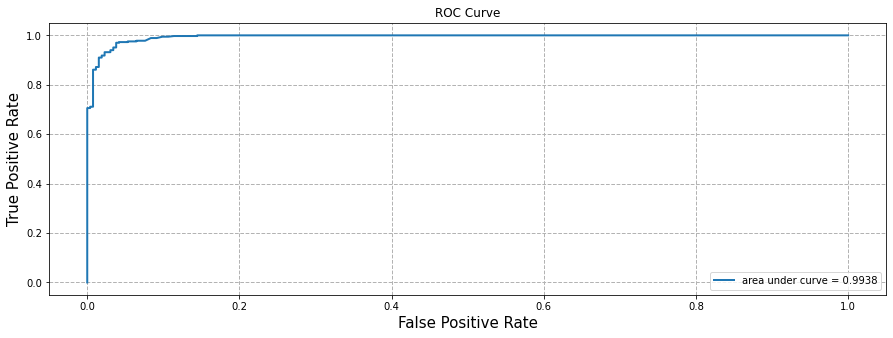

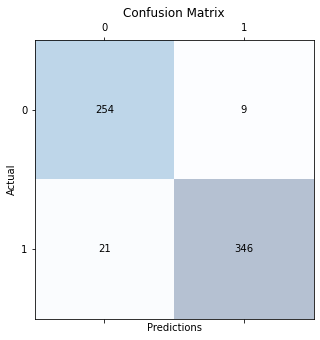

In [15]:
train_SVM(1000, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

For C =  0.0001
Accuracy:  0.5825396825396826
Recall:  1.0
Precision:  0.5825396825396826
F-1 Score:  0.7362086258776329


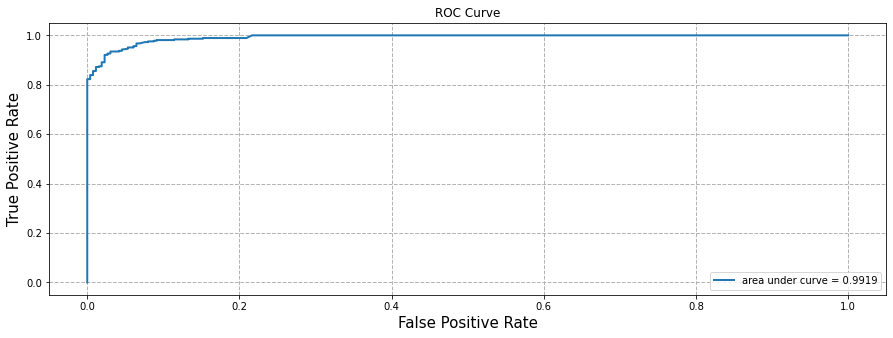

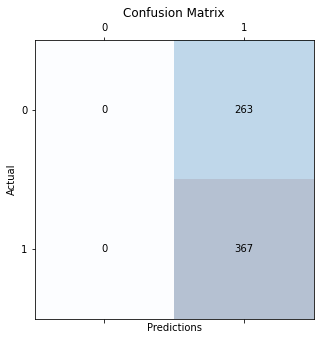

In [16]:
train_SVM(0.0001, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

For C =  100000
Accuracy:  0.9523809523809523
Recall:  0.9455040871934605
Precision:  0.9719887955182073
F-1 Score:  0.9585635359116021


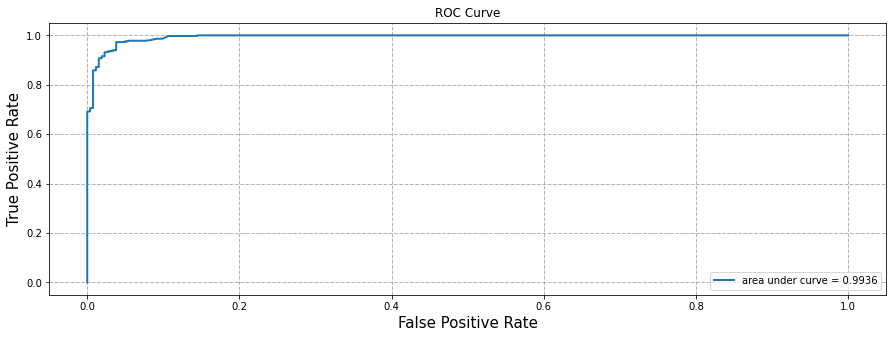

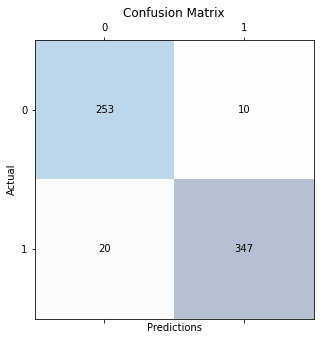

In [17]:
train_SVM(100000, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

- The SVM with γ = 1000 (hard margin) performed better as it had higher metric scores (accuracy, F-1 score, precision) than the soft margin SVM. The hard margin also the same accuracy as the SVM with γ = 100000.
- Gamma is a hyperparameter for the SVM that controls the error when training the SVM. However, since γ = 0.0001 is very low, the SVM is trained to have little error when separating the two classes. This causes the model to overfit the training data and leads to a low accuracy. This low accuracy can be seen by looking at the confusion matrix that shows that model was only able to accurately classify sports categories (shown as 1 in the confusion matrix). However, the model consistently classified climate (0 in the matrix) articles as sports.
    - The ROC curve for the soft margin SVM model does not reflect the performance of the model. The curve implies that it has a high measure of separability, which can imply a good model. While this may be true, a model that has good separability but poor classification accuracy is not a good model. 

Gamma: 0.001 	 Cross Validation accuracy scores: 0.5488095238095239
Gamma: 0.01 	 Cross Validation accuracy scores: 0.5488095238095239
Gamma: 0.1 	 Cross Validation accuracy scores: 0.9273809523809524
Gamma: 1 	 Cross Validation accuracy scores: 0.9392857142857143
Gamma: 10 	 Cross Validation accuracy scores: 0.9452380952380952
Gamma: 100 	 Cross Validation accuracy scores: 0.9452380952380952
Gamma: 1000 	 Cross Validation accuracy scores: 0.9484126984126984
Gamma: 10000 	 Cross Validation accuracy scores: 0.9476190476190476
Gamma: 100000 	 Cross Validation accuracy scores: 0.9484126984126984
Gamma: 1000000 	 Cross Validation accuracy scores: 0.9496031746031747

Best Gamma Value:  1000000
For C =  1000000
Accuracy:  0.9492063492063492
Recall:  0.9400544959128065
Precision:  0.971830985915493
F-1 Score:  0.9556786703601108


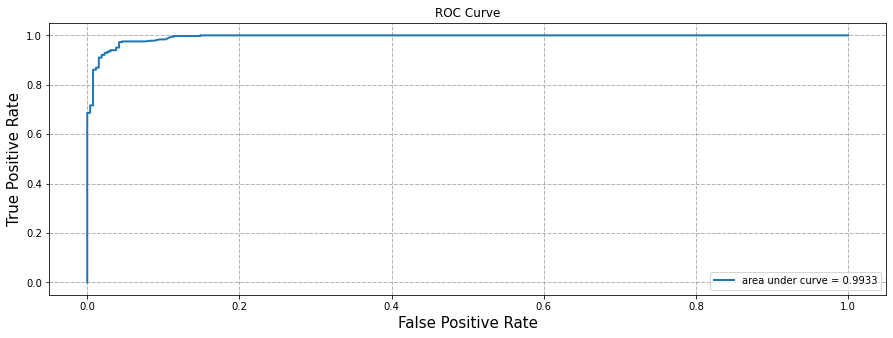

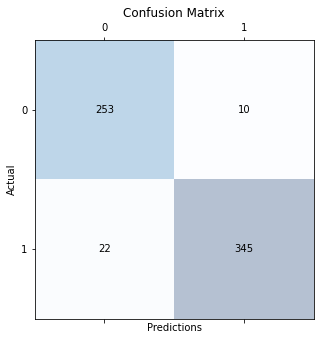

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],  
              'kernel': ['linear']}  
SVM=svm.SVC(random_state=42)
grid = GridSearchCV(SVM, param_grid, cv=5, refit = True, scoring='accuracy',n_jobs=-1) 
grid.fit(train_trunc, train['binary_root_label']) 
grid_predictions = grid.predict(test_trunc) 
   
c_values= [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
for i in range(len(c_values)):
    print('Gamma: %s \t Cross Validation accuracy scores: %s' % (c_values[i],grid.cv_results_['mean_test_score'][i]))
print("\nBest Gamma Value: ", grid.best_params_['C'])
train_SVM(grid.best_params_['C'], train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

The best γ value is 1000000 based on the mean validation accuracy; however, its accuracy is very comparable for gamma values 10 and above.

### Question 6

- Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.
- Find the optimal regularization coefficient: 
    - Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {$10^k$ | − 3 ≤ k ≤ 6, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.
    - Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.
    - How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?
    - Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

In [19]:
from sklearn.linear_model import LogisticRegression

# Logistic regression without regularization
def train_Log(penalty, C, train, train_label, test, test_label):
    Log = LogisticRegression(penalty = penalty, C = C, random_state=42, solver='saga', max_iter=100000)
    Log.fit(train, train_label)
    prob_score = Log.decision_function(test)
    fpr, tpr, _= metrics.roc_curve(test_label,prob_score) # plot roc curve
    plt.plot(fpr, tpr)
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    plt.grid(color='0.7', linestyle='--', linewidth=1)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    predict=Log.predict(test) # get log metrics
    print('Accuracy: ', metrics.accuracy_score(test_label, predict))
    print('Recall: ', metrics.recall_score(test_label, predict))
    print('Precision: ', metrics.precision_score(test_label, predict))
    print('F-1 Score: ', metrics.f1_score(test_label, predict))
    conf_matrix = metrics.confusion_matrix(test_label, predict) # plot confusion matrix
    plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

Logistic Regression, no regularization
Accuracy:  0.953968253968254
Recall:  0.9455040871934605
Precision:  0.9747191011235955
F-1 Score:  0.9598893499308437


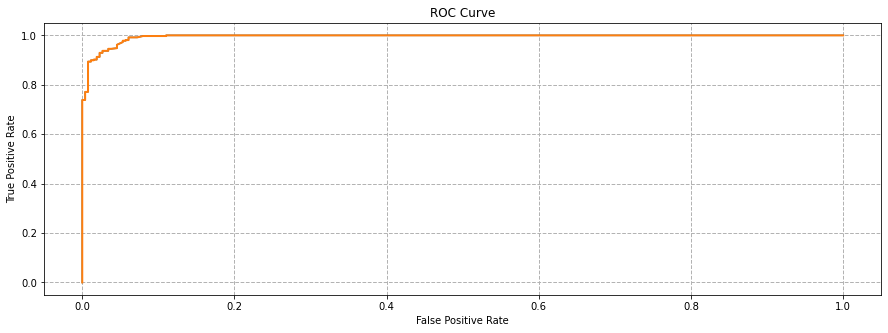

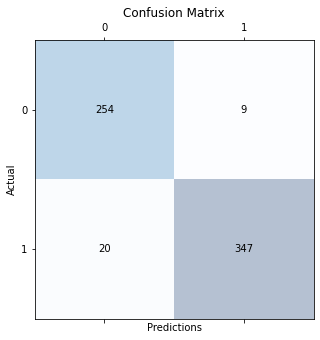

In [20]:
print("Logistic Regression, no regularization")
train_Log('none', 1.0, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

L1 Regularization Results
C: 1e-05 	 Cross Validation accuracy scores: 0.5297619047619048
C: 0.0001 	 Cross Validation accuracy scores: 0.5297619047619048
C: 0.001 	 Cross Validation accuracy scores: 0.5297619047619048
C: 0.01 	 Cross Validation accuracy scores: 0.5488095238095239
C: 0.1 	 Cross Validation accuracy scores: 0.9257936507936508
C: 1 	 Cross Validation accuracy scores: 0.9400793650793651
C: 10 	 Cross Validation accuracy scores: 0.9448412698412698
C: 100 	 Cross Validation accuracy scores: 0.9476190476190476
C: 1000 	 Cross Validation accuracy scores: 0.948015873015873
C: 10000 	 Cross Validation accuracy scores: 0.948015873015873
C: 100000 	 Cross Validation accuracy scores: 0.948015873015873

Best C Value:  1000
Accuracy:  0.953968253968254
Recall:  0.9455040871934605
Precision:  0.9747191011235955
F-1 Score:  0.9598893499308437


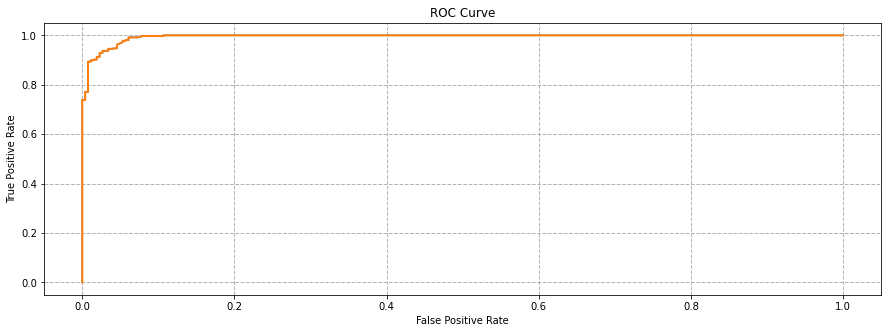

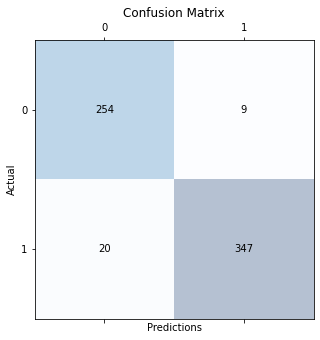

In [21]:
param_grid = {'C': [10**(-5), 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}  

#l1
log_l1 = LogisticRegression(penalty='l1',random_state=42, solver='saga', max_iter=100000)
grid_l1 = GridSearchCV(log_l1, param_grid, cv=5, refit = True, scoring='accuracy',n_jobs=-1) 
grid_l1.fit(train_trunc, train['binary_root_label']) 
grid_predictions_l1 = grid_l1.predict(test_trunc) 
   
print("L1 Regularization Results")
c_values= [10**(-5), 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
for i in range(len(c_values)):
    print('C: %s \t Cross Validation accuracy scores: %s' % (c_values[i],grid_l1.cv_results_['mean_test_score'][i]))

print("\nBest C Value: ", grid_l1.best_params_['C'])
train_Log('l1', grid_l1.best_params_['C'], train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

L2 Regularization Results
C: 1e-05 	 Cross Validation accuracy scores: 0.5488095238095239
C: 0.0001 	 Cross Validation accuracy scores: 0.5488095238095239
C: 0.001 	 Cross Validation accuracy scores: 0.5488095238095239
C: 0.01 	 Cross Validation accuracy scores: 0.6273809523809524
C: 0.1 	 Cross Validation accuracy scores: 0.9222222222222223
C: 1 	 Cross Validation accuracy scores: 0.9420634920634919
C: 10 	 Cross Validation accuracy scores: 0.9448412698412699
C: 100 	 Cross Validation accuracy scores: 0.946031746031746
C: 1000 	 Cross Validation accuracy scores: 0.9476190476190476
C: 10000 	 Cross Validation accuracy scores: 0.948015873015873
C: 100000 	 Cross Validation accuracy scores: 0.948015873015873

Best C Value:  10000
Accuracy:  0.953968253968254
Recall:  0.9455040871934605
Precision:  0.9747191011235955
F-1 Score:  0.9598893499308437


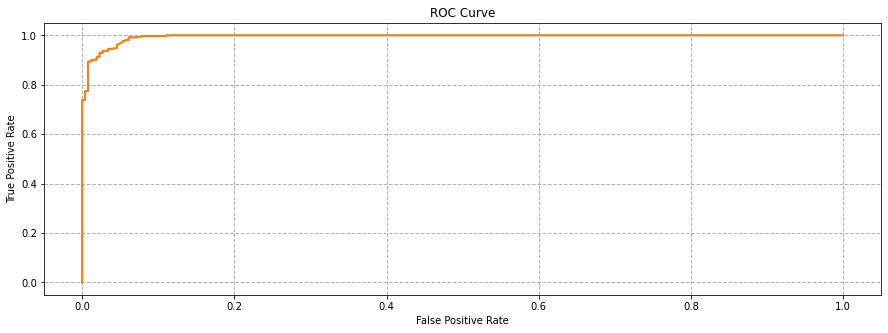

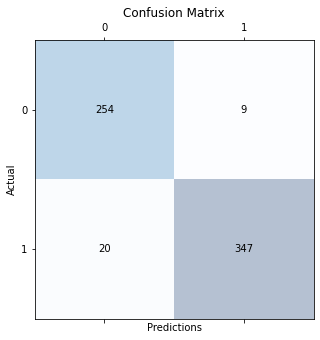

In [22]:
#l2
log_l2 = LogisticRegression(penalty='l2',random_state=42,solver='saga', max_iter=100000)
grid_l2 = GridSearchCV(log_l2, param_grid, cv=5, refit = True, scoring='accuracy',n_jobs=-1) 
grid_l2.fit(train_trunc, train['binary_root_label']) 
grid_predictions_l2 = grid_l2.predict(test_trunc) 
print("L2 Regularization Results")
   
for i in range(len(c_values)):
    print('C: %s \t Cross Validation accuracy scores: %s' % (c_values[i],grid_l2.cv_results_['mean_test_score'][i]))
print("\nBest C Value: ", grid_l2.best_params_['C'])
train_Log('l2', grid_l2.best_params_['C'], train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

- The best C values found for the L1 regularization was 1000, while the best C value for L2 was 10000. The best accuracy, recall, precision, and F-1 scores of the regression with the various regularizations is shown below. The log regressions with their best C parameter gave near identical performance metrics for L1 and L2 as seen from the table. Additionally, they both performed slightly higher than the regression with no reglarization.

| Regularization Type | Accuracy | Recall | Precision | F-1 Score |
| --- | --- | --- | --- | --- | 
|No Regularization | 0.9253968253968254 | 0.9100817438692098 | 0.9597701149425287 | 0.9342657342657343 |
|L1  | 0.953968253968254 | 0.9455040871934605 | 0.9747191011235955 | 0.9598893499308437 |
| L2 |  0.953968253968254 | 0.9455040871934605 | 0.9747191011235955 | 0.9598893499308437 |


- The default value for C is 1.0 for sklearn.linear_model.LogisticRegression; however, the best C value we found for L1 and L2 are 1000 and 10000, respectively. C is a hyperparameter used in the model to tune the regularization strength. This is achieved as regularization prevents overfitting the training data by penalizing outliers in the data. As this helps to generalize the data, it helps to minimize the testing error. In this model, the logistic function with regularization is expressed as ($\dfrac{1}{1+e^{-w^Tx-b}} + \lambda \lVert w \rVert$), where the last term is the regularization term; this regularization term is usually some norm of $w$ multiplied by $\lambda$, such as the L1 or L2 norm. As $w$ is the learned coefficient used to minimise the loss function, $\lambda$ is used to scale the affect of this regularization term which also affects the min $w$ value (which also minimises the loss function).  In L1 regularization, it uses the L1 norm, which minimises the effect of less important features. This is helpful if there are a lot of features present in the data as some features may be more important than others. In L2 regularization, it uses the L2 norm. This is helpful if the features in the data are more equally important and should have more equal weights. Additionally, if $\lambda$ goes to 0, it gets rid of the regularization term.

- In the linear SVM, the underlying algorithm tries to uses a hyerplane or linear as the linear decision boundary to separate the different classes in the data; specificially, it tries to maximises the distance between these classes. In logistic regression, the decision boundary is adapted such that it maximises the maximum likelihood estimation. Therefore, while the SVM considers the distance between classes to the boundary, the logistic regression considers the probability of a data point belonging to a specific class. Their performance differs due to the way they find the decision boundary. Additionally, since the SVM maximises the difference between classes, it is a much less prone to overfitting compared to logistic regression. Additionally, their perfomance differs as logistic regression is based on probability while SVM is more deterministic. In general, they tend to perform similarly for similar tasks; therefore, this difference maybe statistically signification if they are used for drastically different tasks. SVM may be more preferable in tasks such as image classification or text recognization. However, logistic regression may be more preferable when it is harder to separate classes. 

### Question 7

Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

In [23]:
from sklearn.naive_bayes import GaussianNB

# Gnb change decision_fcn to predict_proba, prob_score to prob_score[:,1]
def train_gnb(train, train_label, test, test_label):
    Gnb = GaussianNB()
    Gnb.fit(train, train_label)
    prob_score = Gnb.predict_proba(test)
    fpr, tpr, _= metrics.roc_curve(test_label,prob_score[:,1]) # plot roc curve
    plt.plot(fpr, tpr)
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    plt.grid(color='0.7', linestyle='--', linewidth=1)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    predict=Gnb.predict(test) # get Gnb metrics
    print('Accuracy: ', metrics.accuracy_score(test_label, predict))
    print('Recall: ', metrics.recall_score(test_label, predict))
    print('Precision: ', metrics.precision_score(test_label, predict))
    print('F-1 Score: ', metrics.f1_score(test_label, predict))
    conf_matrix = metrics.confusion_matrix(test_label, predict) # plot confusion matrix
    plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

Accuracy:  0.8936507936507937
Recall:  0.8256130790190735
Precision:  0.9901960784313726
F-1 Score:  0.900445765230312


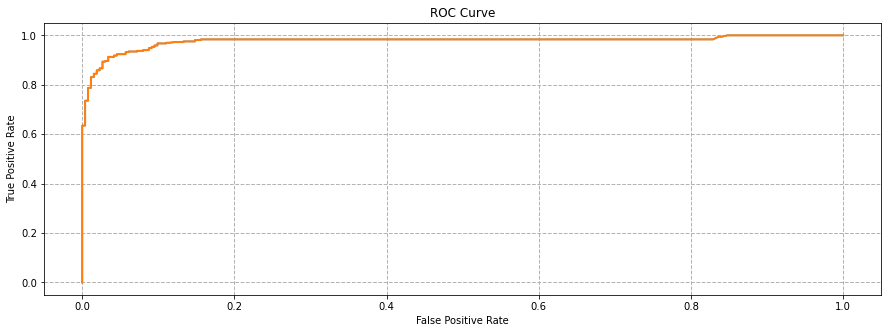

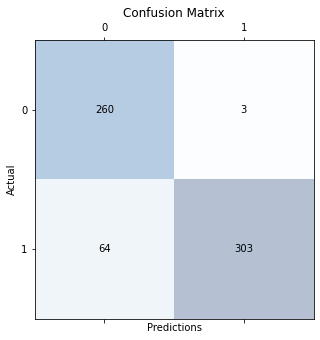

In [24]:
train_gnb(train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

### QUESTION 8
- Construct a Pipeline that performs feature extraction, dimensionality reduction and classification;
- The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).
- In addition to any other hyperparameters you choose, your gridsearch must at least include:

|Module |  Options | 
| --- | --- | 
| Loading Data  | Clean the data | 
| Feature Extraction  | min df = 3 vs 5 while constructing the vocabulary; AND use Lemmatization vs Stemming as a compression module | 
| Dimensionality Reduction  | LSI (k = [5, 30, 80]) vs NMF (k = [5, 30, 80]) | 
| Classifier  | SVM with the best γ previously found vs Logistic Regression: L1 regularization vs L2 regularization, with the best regularization strength previously found vs GaussianNB Note: You can once again find the optimal hyperparameters for each classifier, but this is not required. | 
| Other options | Use default | 

- What are the 5 best combinations? Report their performances on the testing set.

In [25]:
# Loading Data
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import seaborn as sn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('Project1-Classification.csv')

# Seed random generator
np.random.seed(42)
random.seed(42)

# Split data into training and testing data
train, test = train_test_split(df[["full_text","root_label"]], test_size = 0.2)

# Clean Data
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

table = str.maketrans(dict.fromkeys(string.punctuation))

def clean_text(text, table):
    for i in list(text.index):
        text[i] = clean(text[i])
        text[i] = text[i].translate(table)
        text[i] = re.sub(r'\S*\d\S*','',text[i])
        text[i] = text[i].lower()
    return text

train.full_text=clean_text(train.full_text, table)
test.full_text=clean_text(test.full_text, table)

In [26]:
# Feature Extraction

# Create Lemmatizing function
wnl = WordNetLemmatizer()

def get_pos(tag): 
    pos_dict = {'JJ':'a', 'NN':'n', 'RB':'r', 'VB':'v'}
    if tag[1][:2] in list(pos_dict.keys()):
        return pos_dict[tag[1][:2]]
    else:
        return 'n'
    
def lemmatize_text(text): # lemmatize text
    tokens = nltk.word_tokenize(text)
    tags = pos_tag(tokens)
    return  [wnl.lemmatize(pair[0],get_pos(pair)) for pair in tags]

# Create Stemmer 
ps = nltk.stem.PorterStemmer()

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    return [ps.stem(word) for word in tokens]

# transform categories into number (Climate=0, Sports=1)
Encoder = LabelEncoder()
train['binary_root_label']=Encoder.fit_transform(train['root_label'])
test['binary_root_label']=Encoder.fit_transform(test['root_label'])

# Reduce Dimensionality
nmf_5 = NMF(n_components = 5, init='random', random_state=42)
nmf_30 = NMF(n_components = 30, init='random', random_state=42)
nmf_80 = NMF(n_components = 80, init='random', random_state=42)
svd_5 = TruncatedSVD(n_components = 5, random_state=42)
svd_30 = TruncatedSVD(n_components = 30, random_state=42)
svd_80 = TruncatedSVD(n_components = 80, random_state=42)

# Classifiers
l1_logregression = LogisticRegression(penalty='l1',random_state=42, solver='saga', max_iter=100000, C=100)
l2_logregression = LogisticRegression(penalty='l2',random_state=42, solver='saga', max_iter=100000, C=1000)
best_svm = svm.SVC(kernel='linear', C=100000, random_state=42)
gnb = GaussianNB()

In [27]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([ # SVM with best gamma
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=5, init='random', random_state=42)), # dim reduction
    ('clf', svm.SVC(kernel='linear', C=1))])

param_grid = {'vect__min_df': (3,5), # set min_df
              'vect__analyzer': (lemmatize_text, stem_text),  ## add lemmatization and stemming
              'reduce_dim': (nmf_5, nmf_30, nmf_80, svd_5, svd_30, svd_80), # reduce dimensionality
              'clf': (l1_logregression, l2_logregression, best_svm, gnb)}

In [28]:
search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5)
search.fit(train.full_text, train['binary_root_label'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim',
                                        NMF(init='random', n_components=5,
                                            random_state=42)),
                                       ('clf', SVC(C=1, kernel='linear'))]),
             n_jobs=-1,
             param_grid={'clf': (LogisticRegression(C=100, max_iter=100000,
                                                    penalty='l1',
                                                    random_state=42,
                                                    solver='saga'),
                                 LogisticRegressi...
                                        NMF(init='random', n_components=30,
                                            random_state=42),
                    

In [29]:
results=pd.DataFrame(search.cv_results_)
results_subset = results[['param_clf', 'param_reduce_dim','param_vect__analyzer','param_vect__min_df',  'mean_test_score']]
results_subset = results_subset.sort_values(by=['mean_test_score'], ascending=False)
results_subset.iloc[:5]

,param_clf,param_reduce_dim,param_vect__analyzer,param_vect__min_df,mean_test_score
47,"LogisticRegression(C=1000, max_iter=100000, ra...","TruncatedSVD(n_components=80, random_state=42)",<function stem_text at 0x0000025484D76C10>,5,0.955556
46,"LogisticRegression(C=1000, max_iter=100000, ra...","TruncatedSVD(n_components=80, random_state=42)",<function stem_text at 0x0000025484D76C10>,3,0.955159
23,"LogisticRegression(C=100, max_iter=100000, pen...","TruncatedSVD(n_components=80, random_state=42)",<function stem_text at 0x0000025484D76C10>,5,0.954762
71,"SVC(C=100000, kernel='linear', random_state=42)","TruncatedSVD(n_components=80, random_state=42)",<function stem_text at 0x0000025484D76C10>,5,0.954365
22,"LogisticRegression(C=100, max_iter=100000, pen...","TruncatedSVD(n_components=80, random_state=42)",<function stem_text at 0x0000025484D76C10>,3,0.954365


The top 5 classification combinations are shown above. For clarity, the combinations and their rank are also shown below:

| Rank | Classifier | Reduce Dimensionality | Stemming Vs Lemmatization | min_df | Mean Test Score |
| --- | --- | --- | --- | --- | --- |
| 1 | Logistic Regression, L2, C=1000 | LSI, k = 80| Stemming | 5 | 0.955556 |
| 2 | Logistic Regression, L2, C=1000 | LSI, k = 80| Stemming | 3 | 0.955159 |
| 3 | Logistic Regression, L1, C=100 | LSI, k = 80| Stemming | 5 | 0.954762 |
| 4 | SVM, C=100000 | LSI, k = 80| Stemming | 5 | 0.954365 |
| 5 | Logistic Regression, L1, C=100 | LSI, k = 80| Stemming | 3 | 0.954365 |

Additionally, their accuracy, recall, precision, F-1 Score, confusion matrix, and ROC Curve are also shown below. 

In [30]:
tf_vectorizer_3 = CountVectorizer(min_df = 3, stop_words='english', analyzer = stem_text)
train_vectorized_3 = tf_vectorizer_3.fit_transform(train.full_text)
test_vectorized_3 = tf_vectorizer_3.transform(test.full_text)
tf_vectorizer_5 = CountVectorizer(min_df = 5, stop_words='english', analyzer = stem_text)
train_vectorized_5 = tf_vectorizer_5.fit_transform(train.full_text)
test_vectorized_5 = tf_vectorizer_5.transform(test.full_text)

transformer = TfidfTransformer()
train_tfidf_3 = transformer.fit_transform(train_vectorized_3)
test_tfidf_3 = transformer.transform(test_vectorized_3)
train_tfidf_5 = transformer.fit_transform(train_vectorized_5)
test_tfidf_5 = transformer.transform(test_vectorized_5)

train_trunc_3 = svd_80.fit_transform(train_tfidf_3)
test_trunc_3 = svd_80.transform(test_tfidf_3)
train_trunc_5 = svd_80.fit_transform(train_tfidf_5)
test_trunc_5 = svd_80.transform(test_tfidf_5)

1st Ranking Combination
Accuracy:  0.9587301587301588
Recall:  0.9509536784741145
Precision:  0.9775910364145658
F-1 Score:  0.9640883977900553


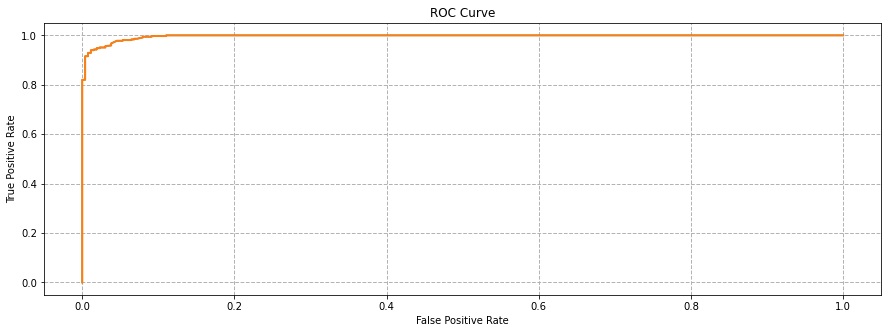

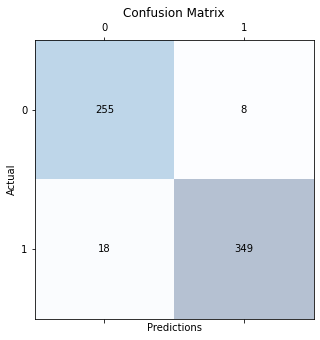

In [31]:
print('1st Ranking Combination')
train_Log('l2', 1000, train_trunc_5, train['binary_root_label'], test_trunc_5, test['binary_root_label'])


2nd Ranking Combination
Accuracy:  0.9634920634920635
Recall:  0.9564032697547684
Precision:  0.9804469273743017
F-1 Score:  0.9682758620689655


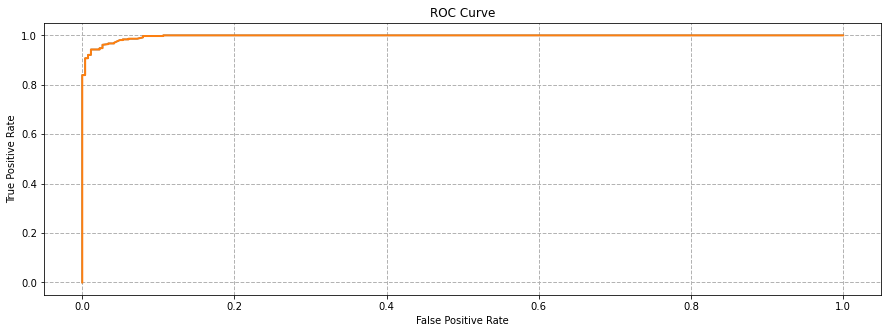

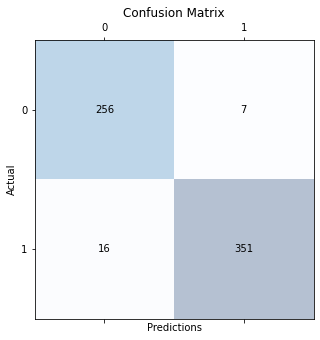

In [32]:
print('2nd Ranking Combination')
train_Log('l2', 1000, train_trunc_3, train['binary_root_label'], test_trunc_3, test['binary_root_label'])


3rd Ranking Combination
Accuracy:  0.9619047619047619
Recall:  0.9536784741144414
Precision:  0.9803921568627451
F-1 Score:  0.9668508287292817


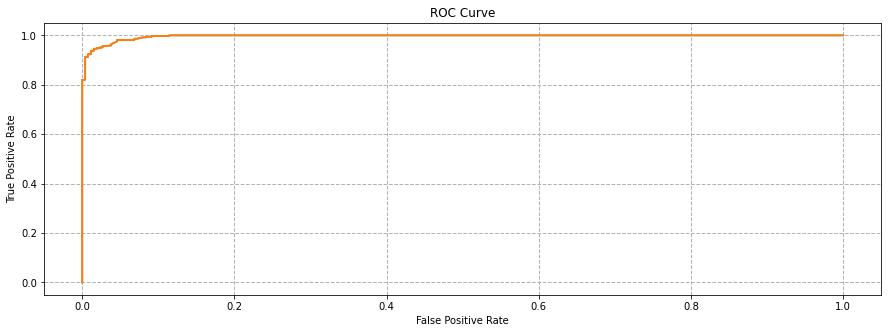

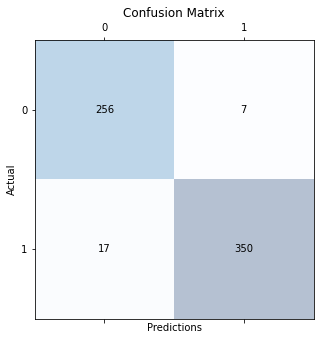

In [33]:
print('3rd Ranking Combination')
train_Log('l1', 100, train_trunc_5, train['binary_root_label'], test_trunc_5, test['binary_root_label'])

4th Ranking Combination
For C =  100000
Accuracy:  0.9619047619047619
Recall:  0.9564032697547684
Precision:  0.9777158774373259
F-1 Score:  0.9669421487603306


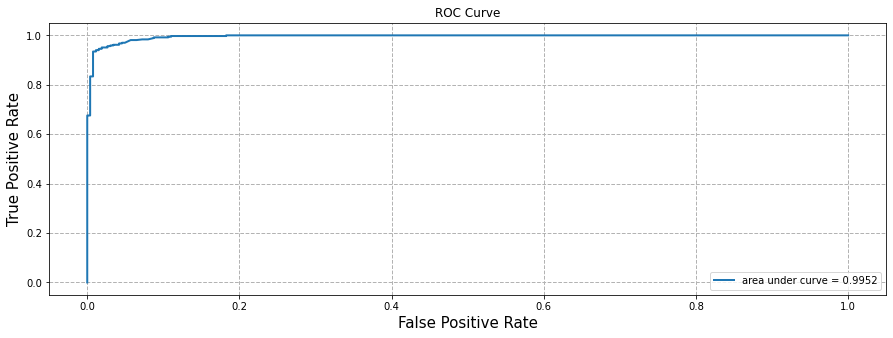

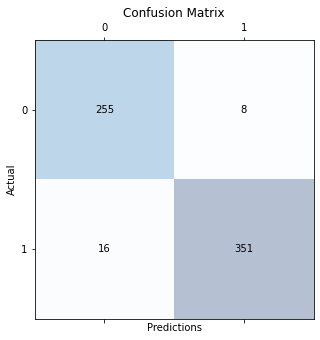

In [34]:
print('4th Ranking Combination')
train_SVM(100000, train_trunc_5, train['binary_root_label'], test_trunc_5, test['binary_root_label'])


5th Ranking Combination
Accuracy:  0.9634920634920635
Recall:  0.9564032697547684
Precision:  0.9804469273743017
F-1 Score:  0.9682758620689655


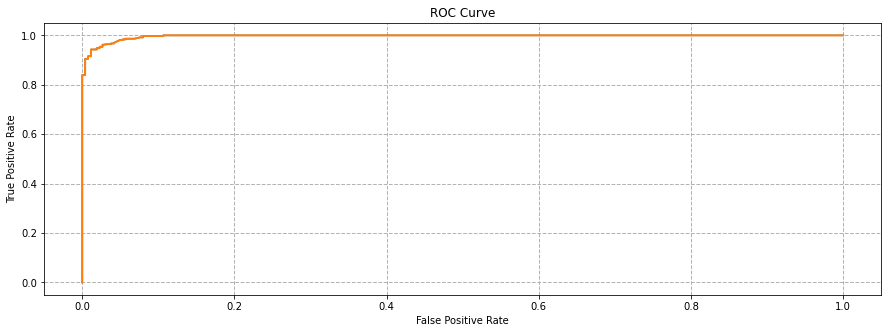

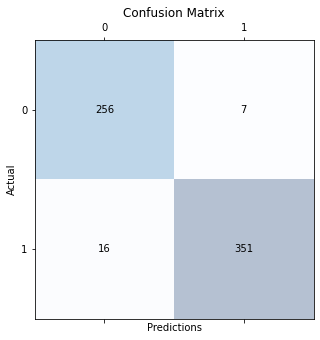

In [35]:
print('5th Ranking Combination')
train_Log('l1', 100, train_trunc_3, train['binary_root_label'], test_trunc_3, test['binary_root_label'])

### QUESTION 9

Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?
In addition, answer the following questions:
- In the confusion matrix you should have an 9 × 9 matrix where 9 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:
`map_row_to_class = {0:"chess", 1:"cricket", 2:"hockey", 3:"soccer",4:"football", 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake", 8:"drought"}`
Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?
- Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?
- Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.


### QUESTION 10: Read the paper about GLoVE embeddings 

(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

- GLoVE embeddings are trained on the ratio of co-occurrence probabilities as they are more likely able to distinguish between relevant and irrelevant words compared to the raw probabilities. Additionally, it is able to better differentiate between the relevant words. 

(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

- It will return the same vector for the word `running` as the word vector contains a list that has all uses of the word. So while the sentences contain the word `running`, the GLoVE embedding for `running` is able to carry both meanings of the word within it. 

(c) What do you expect for the values of, $\lVert GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"] \rVert_2$, $\lVert GLoVE["queen"] - GLoVE["king"]\rVert_2$ and $\lVert GLoVE["wife"] - GLoVE["husband"] \rVert_2$ ? Compare these values.

- $\lVert GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"] \rVert_2 = 6.165036$, $\lVert GLoVE["queen"] - GLoVE["king"]\rVert_2=5.966258$, and $\lVert GLoVE["wife"] - GLoVE["husband"] \rVert_2=3.1520464$. 

(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

- Given a word, we would rather lemmatize a word before mapping it to its GLoVE embedding as stemming may lead to invalid words that are not present in the dictionary. Lemmatizing ensures that the word is valid and will more likely be more accurate once mapped to the GLoVE embedding. 

In [ ]:
import numpy as np
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f: # if 'r' fails with unicode ,→ error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector


In [ ]:
print(np.linalg.norm(embeddings_dict['running']-embeddings_dict['in']-embeddings_dict['the']-embeddings_dict['park']))
print(np.linalg.norm(embeddings_dict['running']-embeddings_dict['in']-embeddings_dict['the']-embeddings_dict['presidency']))

In [ ]:
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']-embeddings_dict['wife']+embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']))
print(np.linalg.norm(embeddings_dict["wife"]-embeddings_dict['husband']))


### Question 11

(a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document. You have to abide by the following rules:
- A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.
- You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.
- Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not.
- To aggregate these words into a single vector consider normalization the vectors, averaging across the vectors.

(b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random
import nltk
from nltk import word_tokenize
np.random.seed(42)
random.seed(42)

train, test = train_test_split(df[["full_text","root_label"]], test_size = 0.2)

train.full_text=clean_text(train.full_text, table)
test.full_text=clean_text(test.full_text, table)

# transform categories into number (Climate=0, Sports=1)
Encoder = LabelEncoder()
train['binary_root_label']=Encoder.fit_transform(train['root_label'])
test['binary_root_label']=Encoder.fit_transform(test['root_label'])

testing_testing=train.full_text[2310]
print(testing_testing)

tokens = nltk.word_tokenize(testing_testing)
